# Inference with custom guides

This is Part III of the time series tutorial https://pyro.ai/time
See also [Part I](https://pyro.ai/time/part_i_inference.ipynb) and
[Part II](https://pyro.ai/time/part_ii_inference.ipynb).

## Data: BART ridership

This section will consider a count time series dataset, the number of BART riders each hour from SFO to Embarcadero.

In [1]:
import torch
import pyro
import pyro.distributions as dist
from matplotlib import pyplot

%matplotlib inline
%config InlineBackend.rc = {'figure.facecolor': (1, 1, 1, 1)}
pyro.enable_validation()
print(pyro.__version__)
print(torch.__version__)

0.4.0
1.2.0


8760


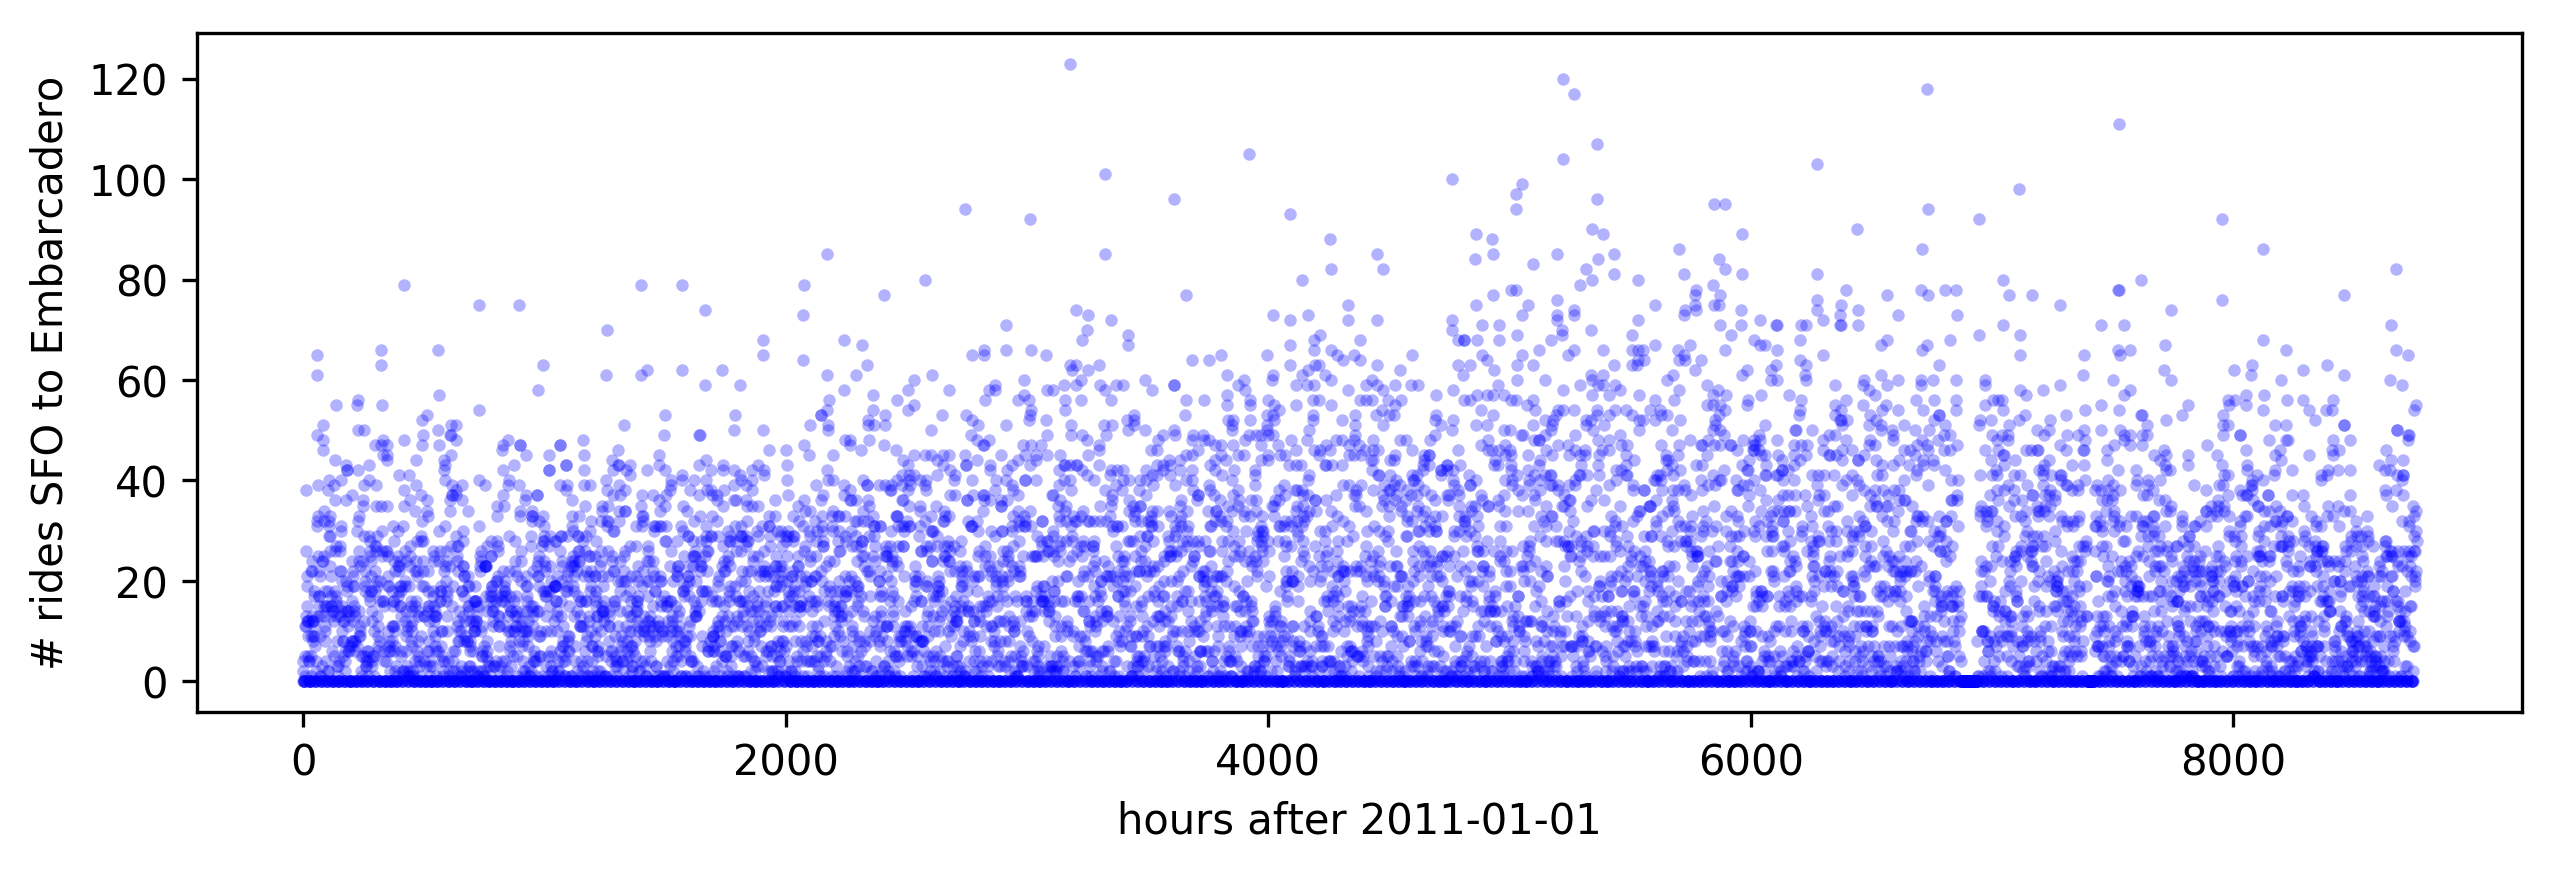

In [2]:
counts = torch.load("data/bart-SFIA-EMBR-2011.pkl")
hours = torch.arange(len(counts))
print(len(counts))

pyplot.figure(figsize=(10, 3), dpi=300)
pyplot.plot(hours.numpy(), counts.numpy(), 'b.', alpha=0.3, markeredgewidth=0)
pyplot.xlabel("hours after 2011-01-01")
pyplot.ylabel("# rides SFO to Embarcadero");

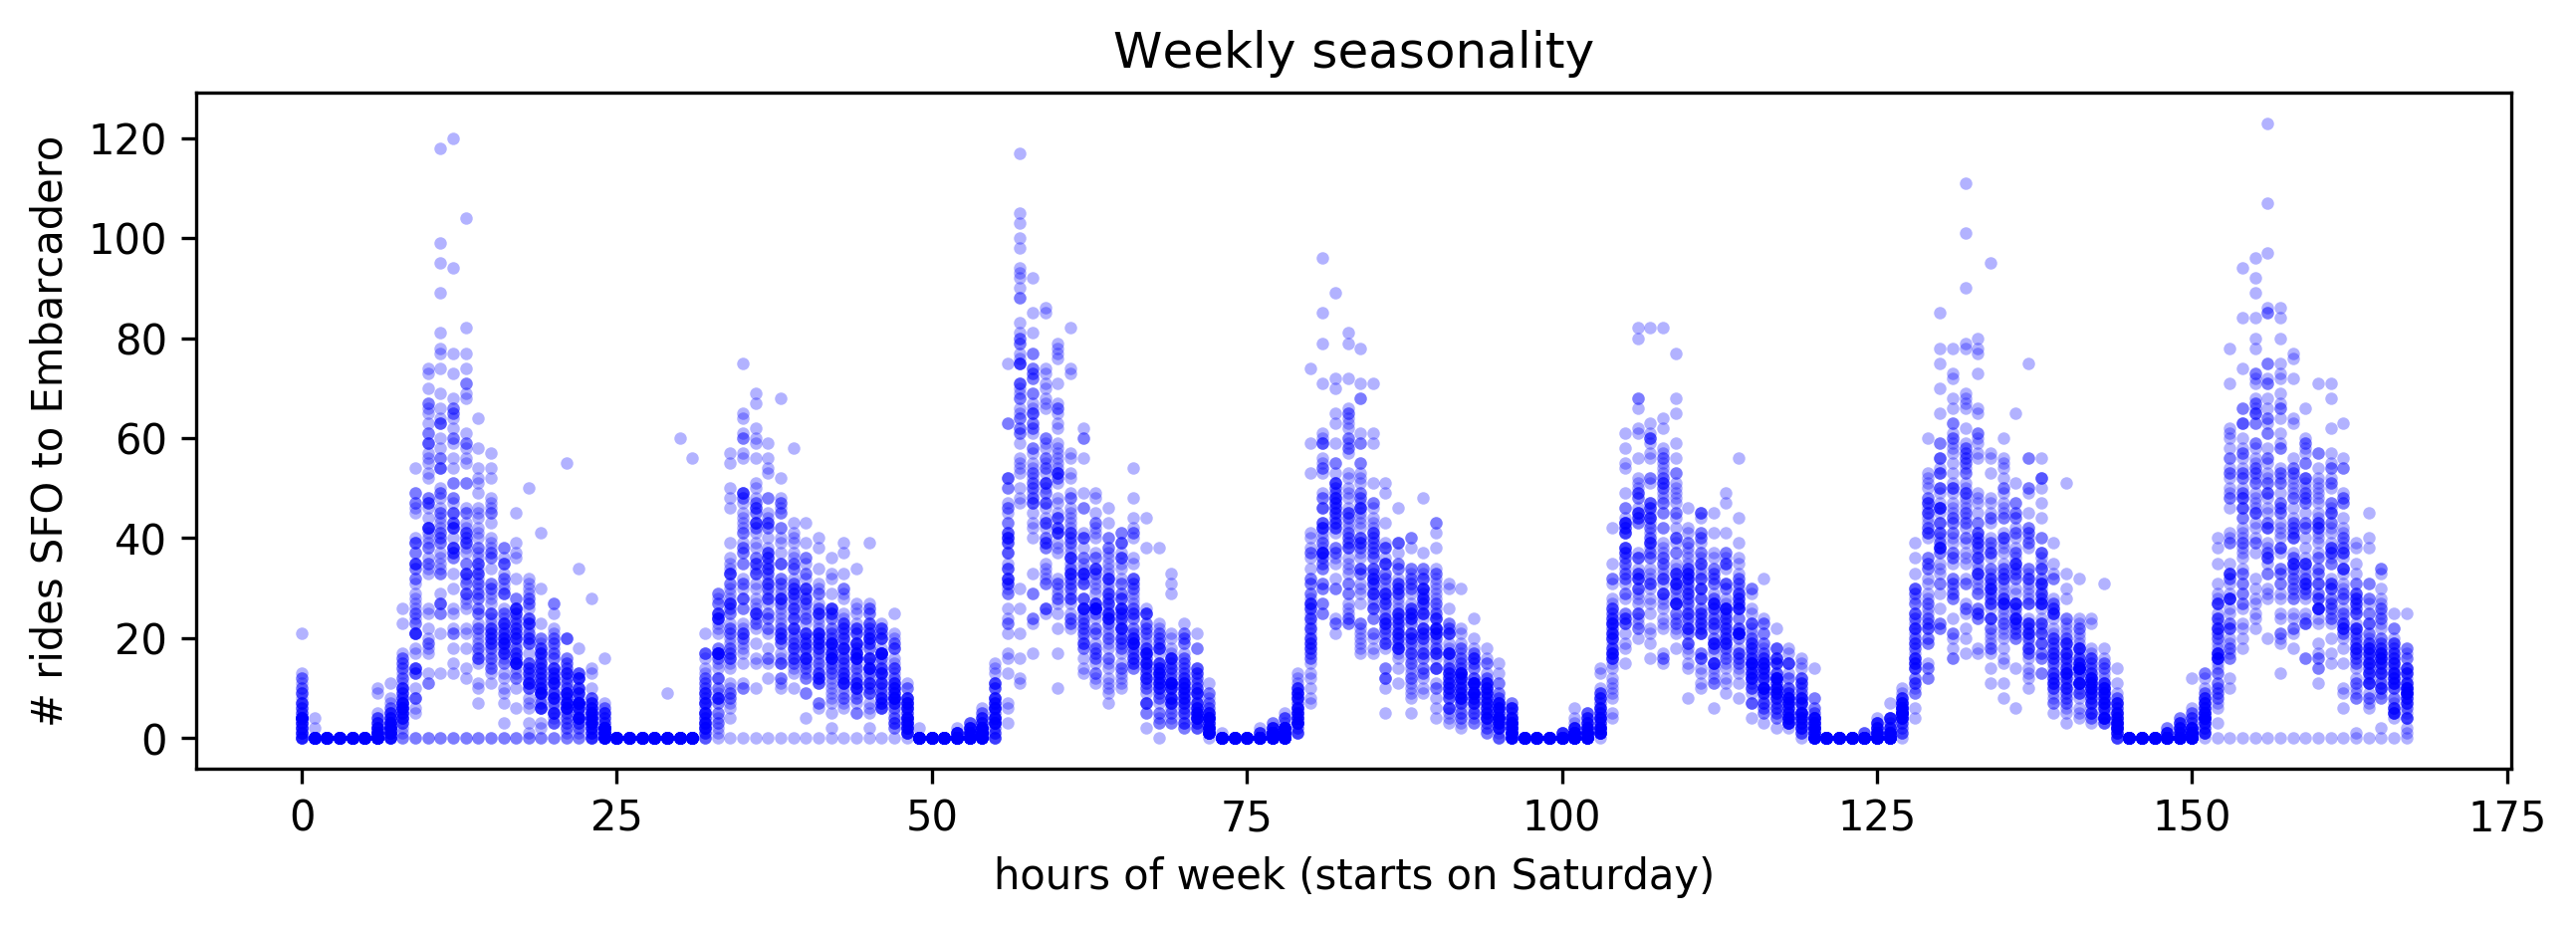

In [3]:
hour_of_week = hours % (24 * 7)

pyplot.figure(figsize=(10, 3), dpi=300)
pyplot.plot(hour_of_week.numpy(), counts.numpy(), 'b.', alpha=0.3, markeredgewidth=0)
pyplot.xlabel("hours of week (starts on Saturday)")
pyplot.ylabel("# rides SFO to Embarcadero")
pyplot.title("Weekly seasonality");

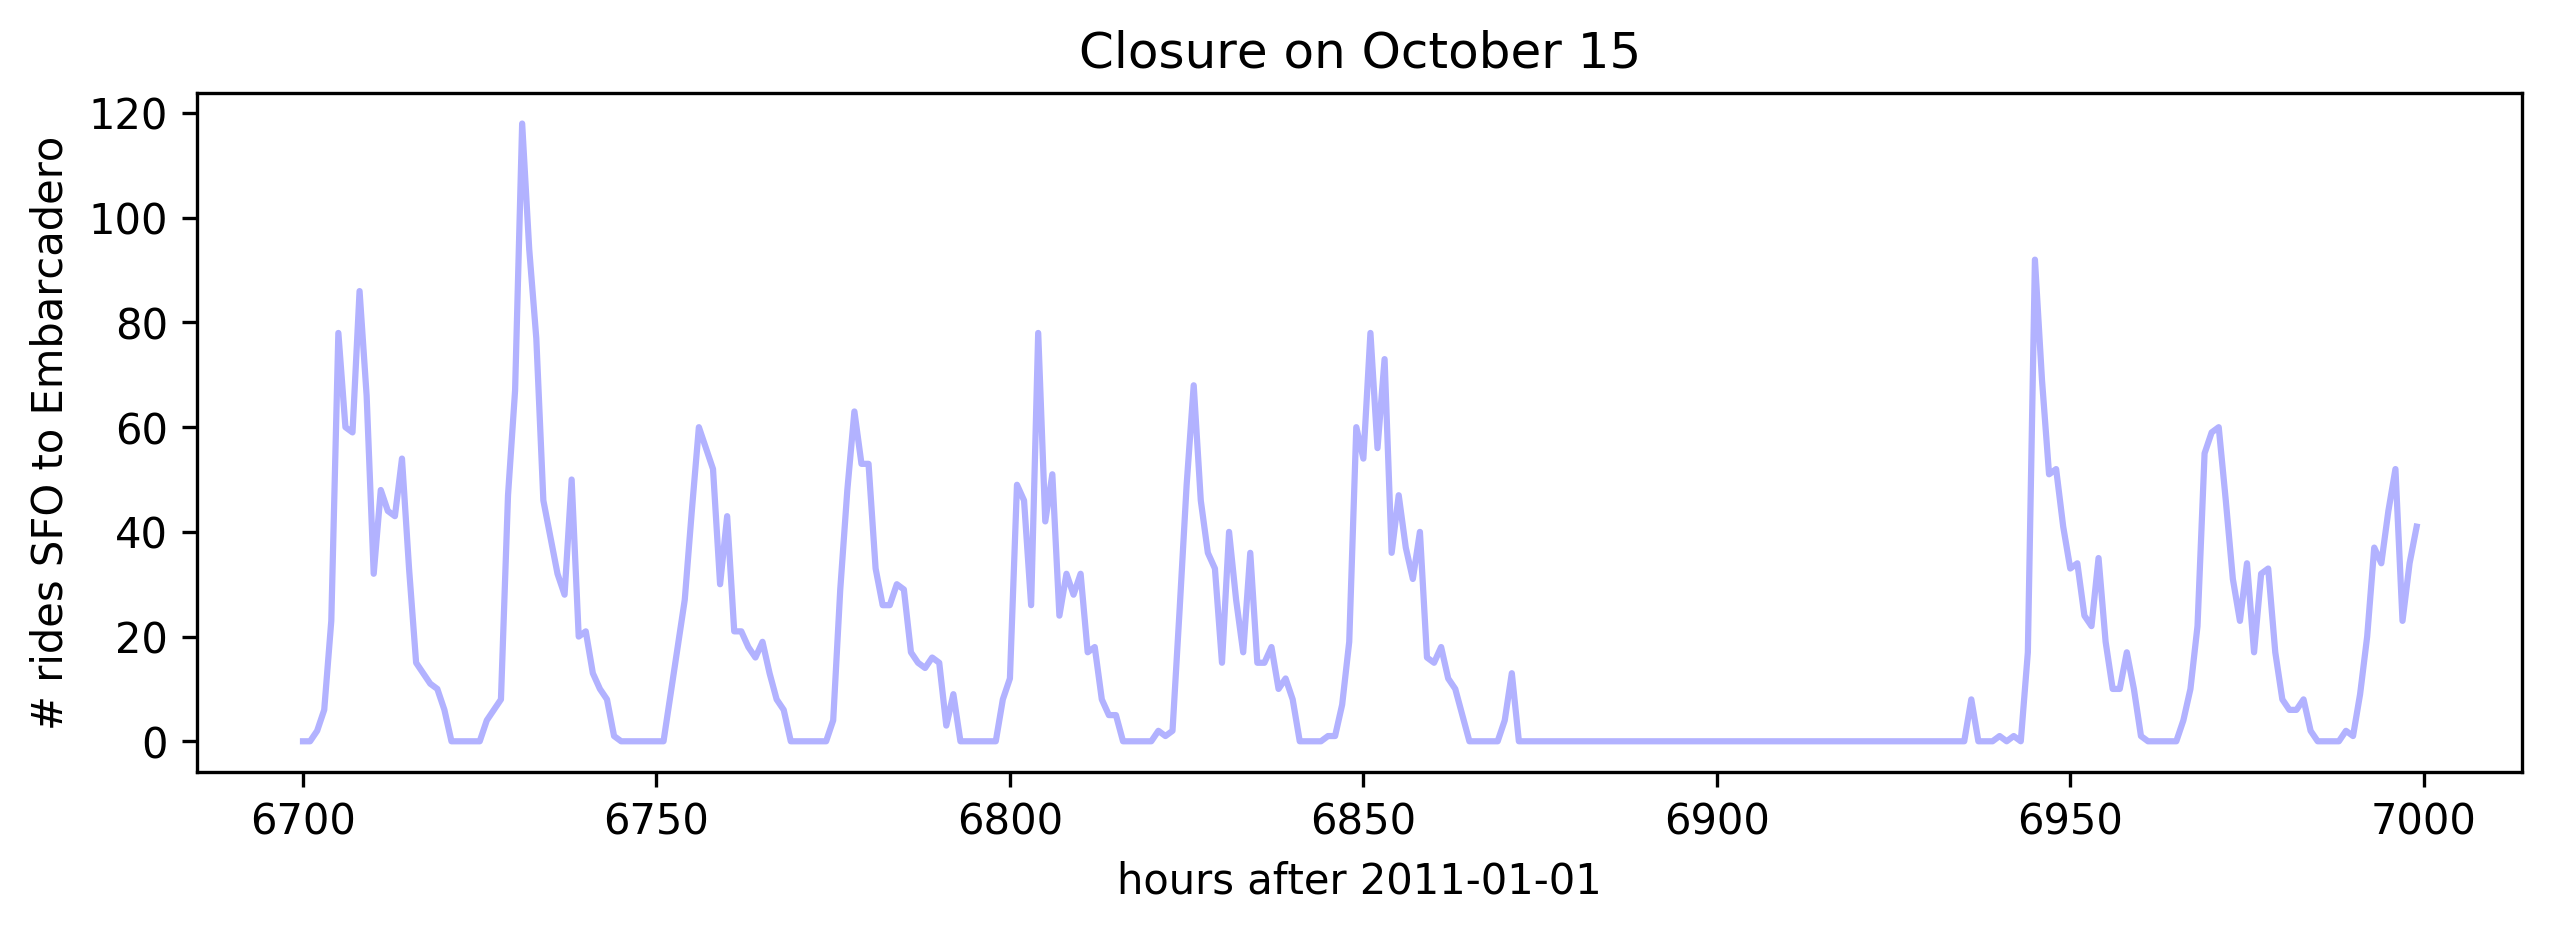

In [4]:
pyplot.figure(figsize=(10, 3), dpi=300)
pyplot.plot(hours[6700: 7000].numpy(),
            counts[6700: 7000].numpy(), 'b-', alpha=0.3, markeredgewidth=0)
pyplot.xlabel("hours after 2011-01-01")
pyplot.ylabel("# rides SFO to Embarcadero")
pyplot.title("Closure on October 15");

## Model: Seasonal + Local trend

Let's consider a Poission model whose latent rate is composed of a seasonal component plus a local Gaussian trend.

Let's model the seasonal aspect by creating a set of features, one for each hour of the week.

In [5]:
features = torch.zeros(len(counts), 24 * 7)
features[torch.arange(len(counts)), hour_of_week] = 1  # one-hot encoding

 We'll first write this model in sequential form.

In [6]:
def model_1(features, counts, init_dist=None):
    # Parameters of the weekly seasonal trend.
    coef = pyro.param("seasonal", torch.zeros(24 * 7))
    log_rate_loc = features @ coef

    # Parameters of a latent Gaussian process.
    if init_dist is None:
        init_dist = dist.MultivariateNormal(torch.tensor([0.]), torch.tensor([[1000.]]))
    trans_matrix = pyro.param("trans_decay", torch.tensor([[0.5]]),
                              constraint=constraints.positive)
    trans_noise = pyro.param("trans_noise", torch.tensor([[1.]]),
                             constraint=constraints.positive)
    trans_dist = dist.MultivariateNormal(torch.zeros(1), trans_noise)
    obs_matrix = torch.tensor([[1.]])
    obs_noise = pyro.param("obs_noise", torch.tensor(1.),
                           constraint=constraints.positive)

    # Sequential time series model.
    rates = []
    state = pyro.sample("state_init", init_dist)
    for t in range(len(counts)):
        state = pyro.sample("state_{}".format(t),
                            dist.MultivariateNormal(state @ trans_matrix,
                                                    scale_tril=trans_noise))
        rate = pyro.sample("rate_{}".format(t),
                           dist.LogNormal(log_rate_loc[t] + state, scale=obs_noise))
        counts[t] = pyro.sample("count_{}".format(t), dist.Poisson(rate),
                                obs=counts[t])

    return torch.cat(counts)  # used later for prediction

## Parallelizing the model

There are two problems with this model.

**First,** we don't know the latent variables `state` and `rate`.

**Second,** this model is sequential over a long time series (8670 time steps), and would be very slow to train.

We will address these problems by using a `GuassianHMM` distribution in the model (which marginalizes out the `state` variable, parallelizing over time), and by using a Variational Autoencoder for a guide (which also operates in parallel).

In [7]:
from torch.distributions import constraints

def model_2(features, counts):
    # Parameters of the weekly seasonal trend.
    coef = pyro.param("seasonal", torch.zeros(24 * 7))
    log_rate_loc = features @ coef

    # Parameters of a latent Gaussian process.
    init_dist = dist.MultivariateNormal(torch.tensor([0.]), torch.tensor([[1000.]]))
    trans_matrix = pyro.param("trans_decay", torch.tensor([[0.5]]),
                              constraint=constraints.positive)
    trans_noise = pyro.param("trans_noise", torch.tensor([[1.]]),
                             constraint=constraints.positive)
    trans_dist = dist.MultivariateNormal(torch.zeros(1), trans_noise)
    obs_matrix = torch.tensor([[1.]])
    obs_noise = pyro.param("obs_noise", torch.tensor(1.),
                           constraint=constraints.positive)
    obs_dist = dist.Normal(log_rate_loc.unsqueeze(-1), obs_noise).to_event(1)

    # A fully vectorized model.
    hmm = dist.GaussianHMM(init_dist, trans_matrix, trans_dist, obs_matrix, obs_dist)
    rates = pyro.sample("log_rates", hmm).squeeze(-1).exp()
    with pyro.plate("time", len(counts)):
        pyro.sample("counts", dist.Poisson(rates), obs=counts)
        
    return hmm  # used later for prediction

## A custom guide

Next we'll implement a custom guide. The guide inputs features and observed `counts` and needs to predict the latent `log_rate` (but not latent `state`, since that was marginalized out). Let's use a linear conv net to create a point estimate.

In [8]:
import torch.nn as nn
conv = nn.Conv1d(1, 1, 7, bias=False, padding=3, padding_mode="same")
conv.weight.data.fill_(0.5 / 7)

def guide(features, counts):
    pyro.module("conv", conv)
    conv_counts = conv(counts.reshape(1, 1, -1).log1p()).squeeze()
    seasonal_loc = features @ pyro.param("seasonal_loc", torch.zeros(24 * 7))
    seasonal_scale = features @ pyro.param("seasonal_scale", torch.zeros(24 * 7))
    loc = conv_counts + seasonal_loc
    scale = seasonal_scale.exp()
    pyro.sample("log_rates", dist.Normal(loc.unsqueeze(-1),
                                         scale.unsqueeze(-1)).to_event(2))

## Training

So far we created a model and a guide. These are two parts of a Variational Autoencoder.

Next we can train the model and guide together using Stochastic Variational Inference (SVI). We'll use a generic deep learning optimizer.

Before we train, let's split data into a train and test part.

In [9]:
split = 8400
features_train, features_test = features[:split], features[split:]
counts_train, counts_test = counts[:split], counts[split:]

## Initialize before training

I find that initialization is very important: it always pays off to think about smart initialization of parameters, so that the initial guide and model are plausible, and thus the optimizer merely fine tunes the parameters. Good initialization also speeds up training and speeds up Box's cycle of criticism and model iteration.

In [10]:
%%time
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
pyro.clear_param_store()
pyro.set_rng_seed(1)

# Initialize parameters to a 10 week mean.
init_coef = counts[:10 * 24 * 7].reshape(10, 24 * 7).mean(0).log1p()
pyro.param("seasonal", init_coef)
pyro.param("seasonal_loc", init_coef)

svi = SVI(model_2, guide, Adam({"lr": 0.02}), Trace_ELBO())
for i in range(501):
    loss = svi.step(features_train, counts_train)  # args are passed to guide() and model_2()
    if i % 25 == 0:
        print("loss = {}".format(loss / len(counts_train)))  # normalize per hour

loss = 79.02114222935268
loss = 9.51208763485863
loss = 7.595435325985863
loss = 6.128752034505208
loss = 5.30647449311756
loss = 4.803463076636905
loss = 4.556911359514509
loss = 4.289860316685268
loss = 4.1153585088820686
loss = 4.038267429896764
loss = 3.9787668863932293
loss = 3.8453623744419643
loss = 3.797626219249907
loss = 3.7257195318312872
loss = 3.6665887015206473
loss = 3.653982352302188
loss = 3.6037510499500094
loss = 3.6237231808617003
loss = 3.599342251732236
loss = 3.5674908083961125
loss = 3.571292412167504
CPU times: user 17.3 s, sys: 649 ms, total: 17.9 s
Wall time: 15.8 s


## Sanity check the trained model

As a sanity check, we can examine the seasonal parameter.

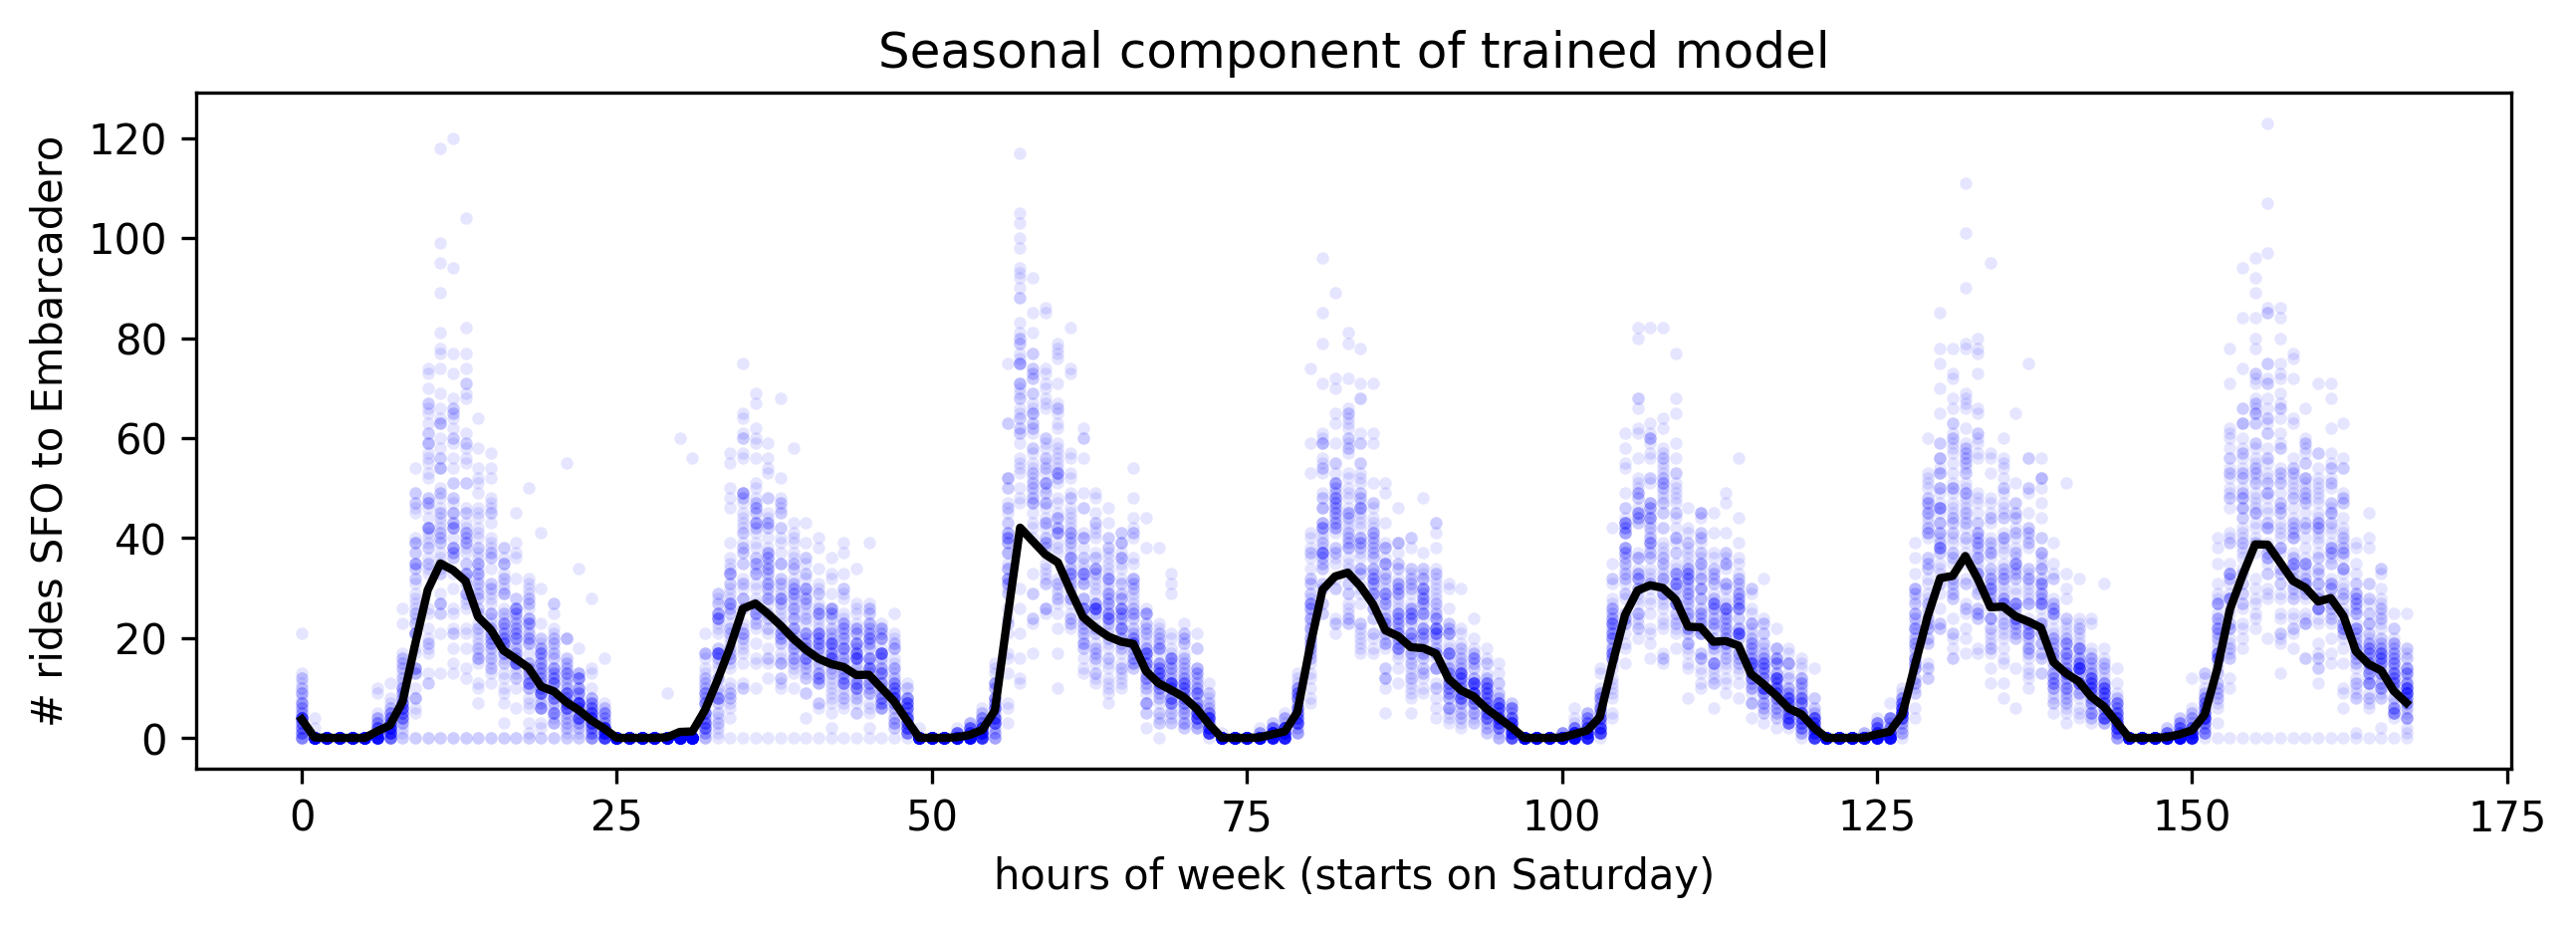

In [11]:
pyplot.figure(figsize=(10, 3), dpi=300)
pyplot.plot(hour_of_week.numpy(), counts.numpy(), 'b.', alpha=0.1, markeredgewidth=0)
pyplot.plot(hour_of_week[:24 * 7].numpy(),
            pyro.param("seasonal").detach().exp().numpy(), "k-", lw=2)
pyplot.xlabel("hours of week (starts on Saturday)")
pyplot.ylabel("# rides SFO to Embarcadero")
pyplot.title("Seasonal component of trained model");

It also looks like the noise parameters have sane looking values:

In [12]:
for name, value in pyro.get_param_store().items():
    if value.numel() < 20:
        print("{} = {}".format(name, value.detach()))

conv$$$weight = tensor([[[-0.0178, -0.0245, -0.0461,  0.2659, -0.0524, -0.0353, -0.0213]]])
trans_decay = tensor([[0.8012]])
trans_noise = tensor([[0.0217]])
obs_noise = 0.22988146543502808


## Predicting future states

We've seen two model versions so far: a sequential `model_1` and a parallel `model_2`.

To predict future data we'll need to combine these two models and the guide. We'll use the trained `guide` and `model_2` to infer latent state at the last observed time, then use `model_1()` to sample forward past what we've observed.

To combine the three models we'll use the effect handlers `trace` and `replay`, as we saw in Part I. First we'll record the `guide`, replay `model_2` to get a `GaussianHMM` object, and use the `GaussianHMM.filter()` method to get the posterior latent state at the final time step of training data.

In [13]:
from pyro import poutine

with torch.no_grad():
    guide_trace = poutine.trace(guide).get_trace(features_train, counts_train)
    hmm = poutine.replay(model_2, guide_trace)(features_train, counts_train)
    init_dist = hmm.filter(guide_trace.nodes["log_rates"]["value"])

Next we can use `init_dist` in model_1 to sample new counts.

In [14]:
with torch.no_grad():
    counts_pred = model_1(features_test, [None] * len(counts_test), init_dist=init_dist)
print(counts_pred.shape)

torch.Size([360])


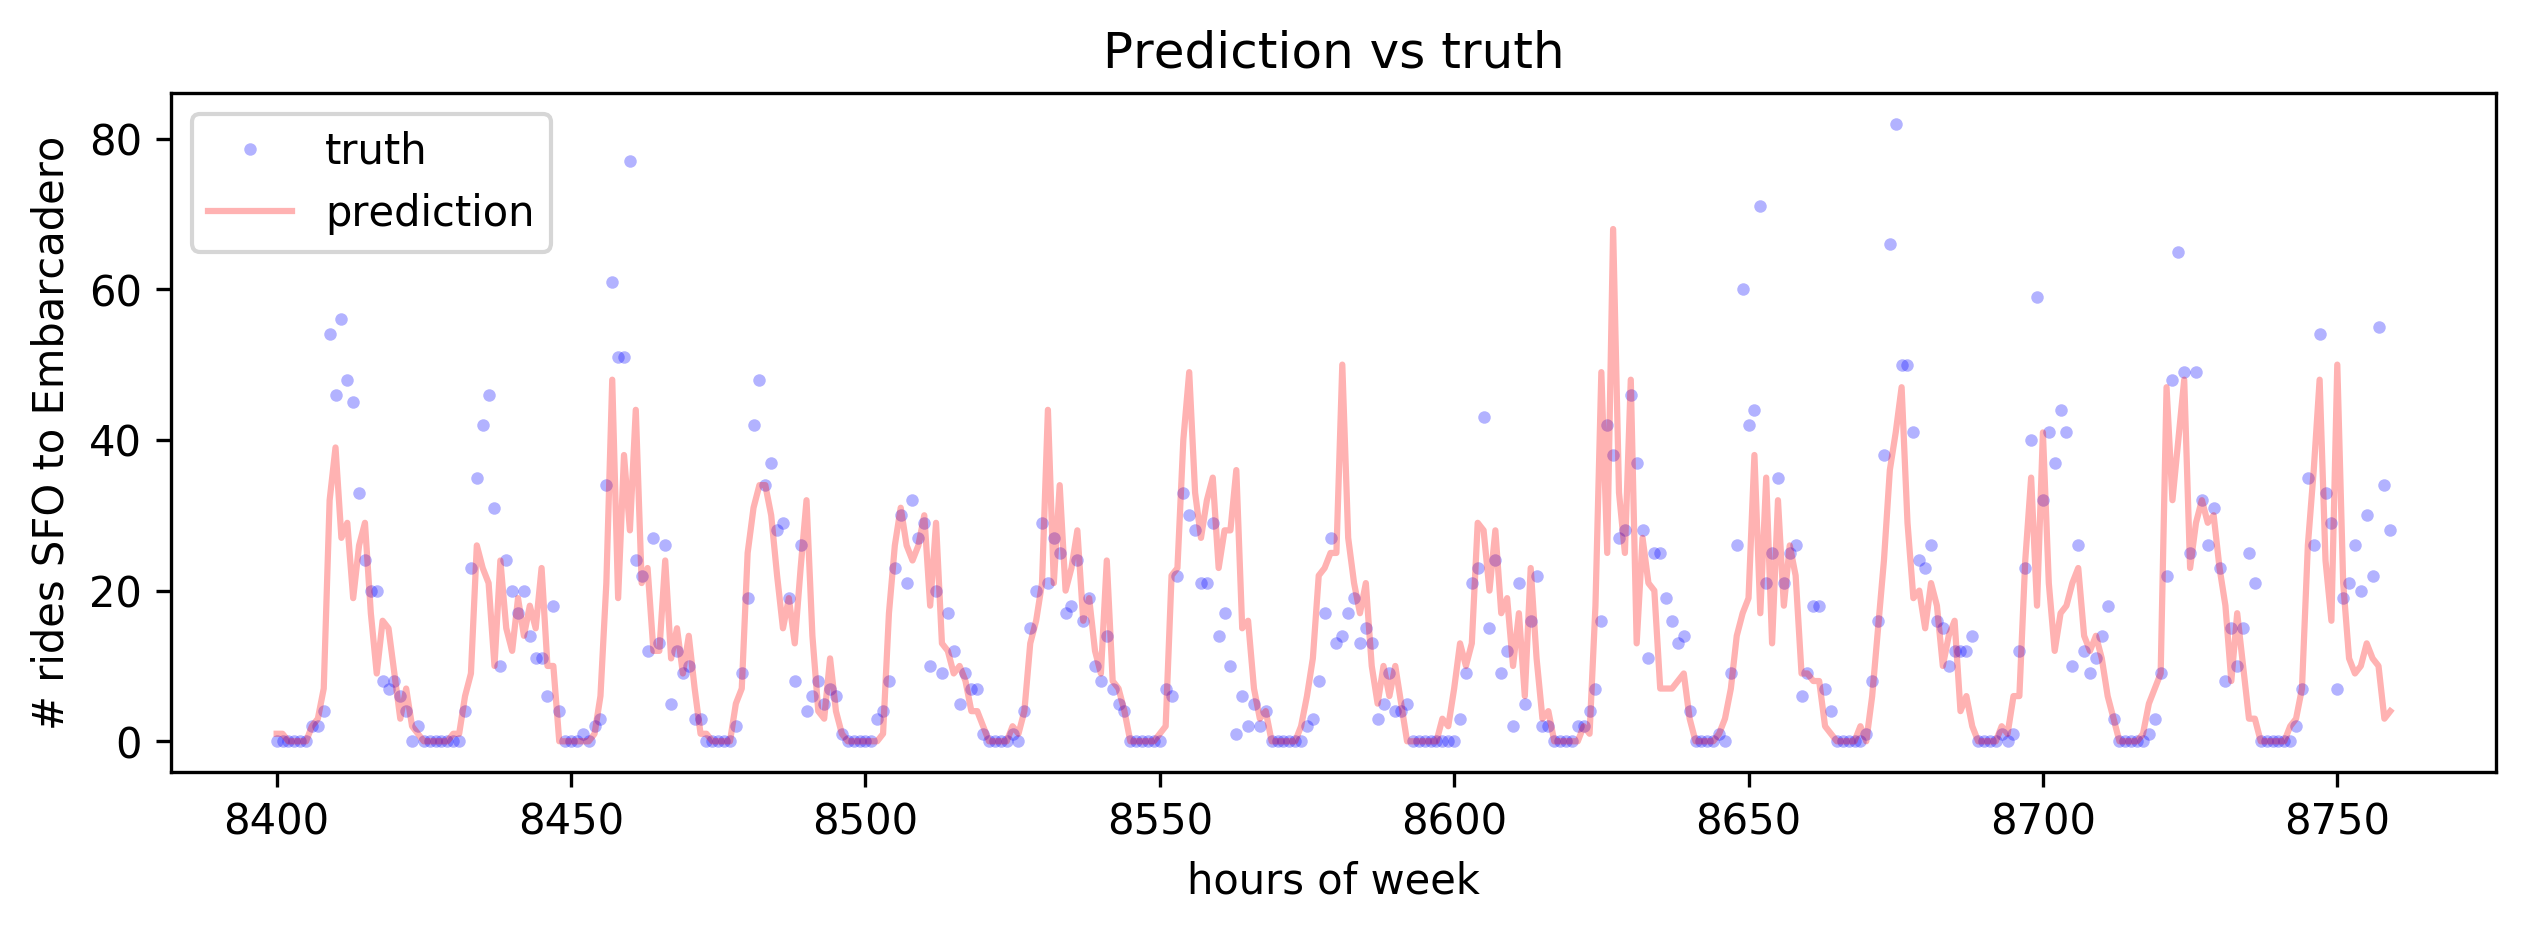

In [15]:
pyplot.figure(figsize=(10, 3), dpi=300)
pyplot.plot(hours[split:].numpy(),
            counts_test.numpy(), 'b.', alpha=0.3, markeredgewidth=0, label="truth")
pyplot.plot(hours[split:].numpy(),
            counts_pred.numpy(), 'r-', alpha=0.3, label="prediction")
pyplot.xlabel("hours of week")
pyplot.ylabel("# rides SFO to Embarcadero")
pyplot.title("Prediction vs truth")
pyplot.legend();

## Predicting with uncertainty

Let's wrap our predictor up in a function and draw multiple samples.

In [16]:
@torch.no_grad()
def forecast():
    guide_trace = poutine.trace(guide).get_trace(features_train, counts_train)
    hmm = poutine.replay(model_2, guide_trace)(features_train, counts_train)
    init_dist = hmm.filter(guide_trace.nodes["log_rates"]["value"])
    return model_1(features_test, [None] * len(counts_test), init_dist=init_dist)

In [17]:
%%time
samples = torch.stack([forecast() for _ in range(100)])
print(samples.shape)

torch.Size([100, 360])
CPU times: user 10.8 s, sys: 115 ms, total: 10.9 s
Wall time: 10.7 s


In [18]:
low = samples.kthvalue(10, dim=0)[0]
high = samples.kthvalue(90, dim=0)[0]

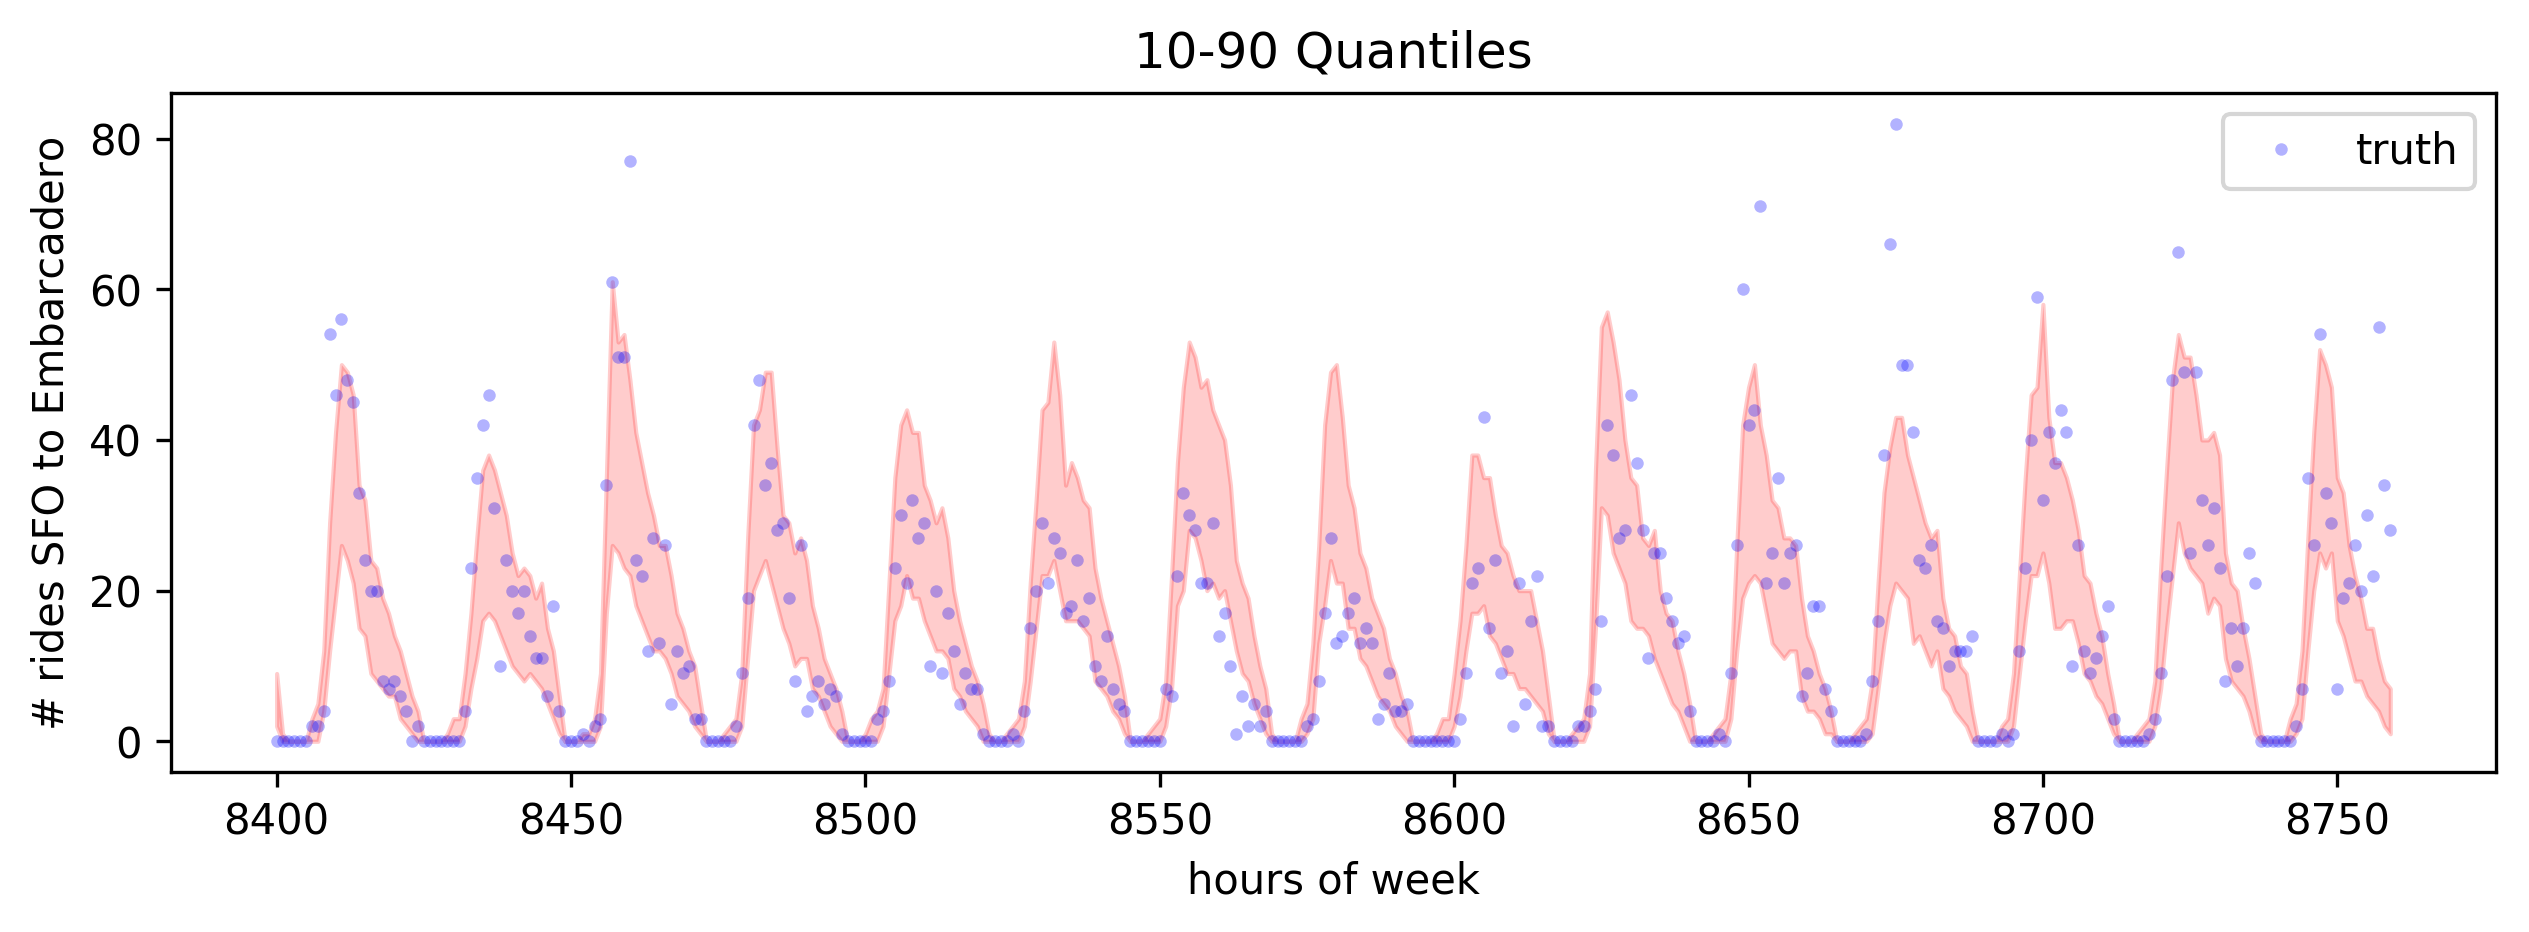

In [19]:
pyplot.figure(figsize=(10, 3), dpi=300)
pyplot.plot(hours[split:].numpy(),
            counts_test.numpy(), 'b.', alpha=0.3, markeredgewidth=0, label="truth")
pyplot.fill_between(hours[split:].numpy(), low.numpy(), high.numpy(), color='red', alpha=0.2)
pyplot.xlabel("hours of week")
pyplot.ylabel("# rides SFO to Embarcadero")
pyplot.title("10-90 Quantiles")
pyplot.legend();